# Example: Sell-Side Trade Negotiation

The only component you must write to use `negmas-rl` is a function that can generate scenarios appropriate to the task the RL agent is trained to solve.

<div class="admonition note">
    <p class="admonition-title">Note</p>
    <p>
        Actually, you do not really need to write a ScenarioGenerator as some are already provided by default in negmas-rl but for most realistic cases, you will.
    </p>
</div>

In our example, we will use the task of training a **sell-side negotiator** in a trading scenario. The issues being negotiated are: *price*, *quantity* and *carbon emission*. We can write this generator simply as follows:


In [1]:
# This cell contains only imports.
from functools import partial
from pathlib import Path

import matplotlib.pyplot as plt
from negmas import (
    LambdaFun,
    LinearTBNegotiator,
    SAOMechanism,
)
from negmas.gb.negotiators import BoulwareTBNegotiator, ConcederTBNegotiator
from negmas.inout import Scenario
from negmas.outcomes import make_issue, make_os
from negmas.preferences import LinearUtilityAggregationFunction as LU
from negmas.preferences.value_fun import AffineFun, TableFun
from negmas_rl.action import DefaultActionDecoder
from negmas_rl.env import NegoEnv
from negmas_rl.generators.assigner import PositionBasedNegotiatorAssigner
from negmas_rl.generators.mechanism import MechanismRepeater
from negmas_rl.generators.negotiator import NegotiatorRepeater
from negmas_rl.negotiator import SAORLNegotiator
from negmas_rl.obs import DefaultObsEncoder
from rich import print
from stable_baselines3.sac import SAC

In [4]:
def TradeScenarioGenerator(indx: int | None = None) -> Scenario:
    """Defines the scenarios used for training/testing"""
    # 1. Define the outcome space
    os = make_os(
        [
            make_issue((1, 5), "price"),
            make_issue((1, 20), "quantity"),
            make_issue(["high", "med", "low"], "carbon emission"),
        ],
        name="Trade",
    )
    # 2. Define the sell-side utility function
    seller_ufun = LU(
        (
            AffineFun(1 / 4, -1 / 4),
            AffineFun(1 / 19, -1 / 19),
            TableFun(dict(high=1.0, med=0.5, low=0.0)),
        ),
        weights=(0.7, 0.2, 0.1),
        outcome_space=os,
        reserved_value=0.0,
    )        

    # 3. Define  the buy-side utility function
    buyer_ufun = LU(
        (
            AffineFun(-1 / 4, 5 / 4),
            LambdaFun(
                lambda x: x / 4 - 1 / 4 if x <= 5 else (-1 / 15) * (x - 4) + 16 / 15
            ),
            TableFun(
                dict(
                    high=0.0,
                    med=0.8,
                    low=1.0,
                )
            ),
        ),
        weights=(0.4, 0.4, 0.2),
        outcome_space=os,
        reserved_value=0.0,
    )
    
    # 4. Return the constructed scenario
    return Scenario(os, (seller_ufun, buyer_ufun))  # type: ignore

## Running an example session

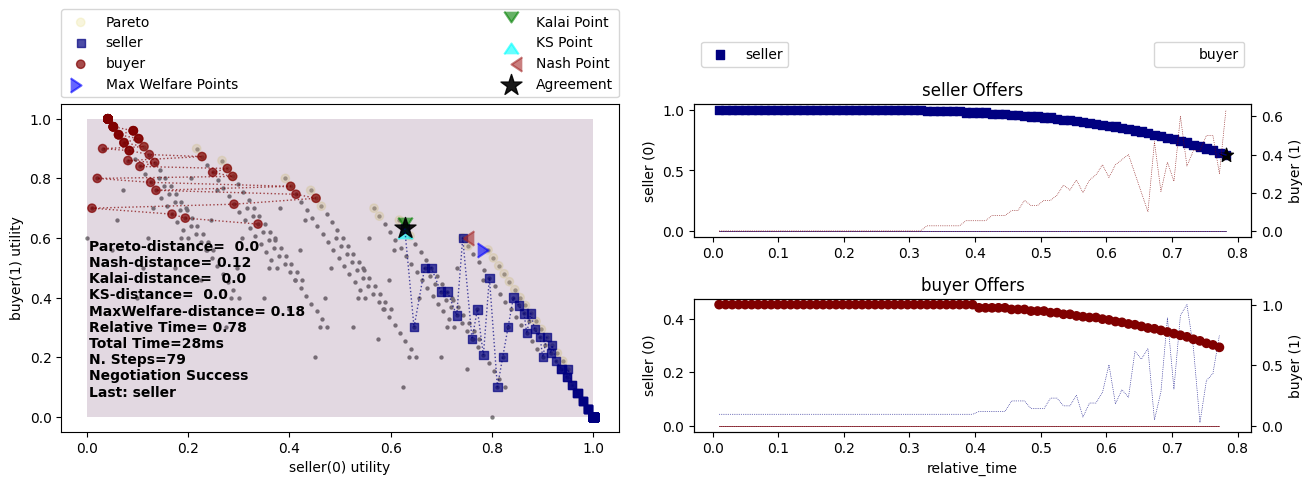

In [16]:
m = TradeScenarioGenerator().make_session(
    n_steps=100, 
    negotiators=[
        BoulwareTBNegotiator(name="seller"), 
        BoulwareTBNegotiator(name="buyer")
    ]
)
m.run()
m.plot()
plt.show()

## Defining the Environment

Once you have the scenario generator, you can easily create an appropriate negotiation environment which is a `gymnasium` environment compatible with any RL algorithm. For example

In [3]:
def make_env():
    """Makes a trading environment."""
    return NegoEnv(
        scenario_generator=TradeScenarioGenerator,
        partner_generator=NegotiatorRepeater(LinearTBNegotiator),        
        assigner=PositionBasedNegotiatorAssigner(always_starts=True),
        mechanism_generator=MechanismRepeater(
            SAOMechanism, dict(n_steps=100)
        ),
    )

Other than the scenario generator, you will need to pass the following:

1. A **partner_generator** for generating partners during training (and testing). Here we simply use a **LinearTBNegotiator** from negmas. You can cycle through sets of negotiators or use any other method for generating the partners that are not learning during the negotiation.
2. An **assigner** which is responsible for assigning the learner and its partner(s) to their utility functions and place in the negotiation. Here we simply assign our learner to the first ufun (*seller*) everytime.
3. A **mechanism_generator** which create the negotiation mechanism used for negotiation. Here we simply used the Alternating Offers Protocol (**SAOMechanism**) with $100$ negotiation rounds.

## Training

Now that we can create the environment, we can apply any RL training method directly to it. Here we use SAC from `stable-baselines3`:

In [4]:
NTRAIN, NTEST = 10_000, 500
def make_trainer(policy="MultiInputPolicy"):
    """Trains a model."""
    env = make_env()
    trainer = SAC(policy=policy, env=env)
    return trainer
    
def train(trainer, steps=NTRAIN):
    """Trains a model."""    
    return trainer.learn(steps, progress_bar=True)      

Let's run a training (we will also keep an untrained model for testing in the future)

In [5]:
untrained = make_trainer()
trained = train(make_trainer())

 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 9,982/10,000  [ 0:01:19 < 0:00:01 , 126 it/s ]

## Testing

The easiest way to test the model is to just create another environment and step through it collecting rewards. Here is an example:

In [6]:
def make_policy(obs, model):
    """Wrapps a stable-baselines3 model to create actions"""
    return model.predict(obs)[0]
    
def test(model):
    """Tests a model."""
        
    # 1. create the environment
    env = make_env()
    # 2. Wrap the model 
    policy = partial(make_policy, model=model)
    # 3. Reset the environment
    obs, _ = env.reset()
    reward = 0
    # 4. Loop collecting rewards.
    for _ in range(NTEST):
        obs, r, terminated, truncated, _ = env.step(policy(obs))
        reward += r
    # 5. Close the environment
    env.close()    
    return reward / env.n_negotiations

As an example, let's test an untrained model:

In [7]:
print(f"Untrained model got {test(untrained):3.2}")
print(f"Trained model got {test(trained):3.2}")

Untrained model got 0.042

Trained model got 0.26

We got a  low score for the untrained model and a higher score for the trained model.
We can continue the training and test again

In [8]:
trained = train(trained, NTRAIN * 2)
print(f"Trained model got {test(trained):3.2}")

 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 19,985/20,000  [ 0:02:32 < 0:00:01 , 120 it/s ]

Trained model got 0.76

As expected, we got an even higher score.

## Deployment

Now that we know how to train and test the model, we can deply it. This is a little more complicated but not much.

In [9]:
from random import choice
def test_negotiation(model, partner_types=(BoulwareTBNegotiator, ConcederTBNegotiator)):
    """Deploys a model and tests it in actual negotiations."""
    def shorten(x):
        return x.replace("SAO", "").replace("Negotiator", "")
    # 1. Create the negotiation scenario
    s = TradeScenarioGenerator()

    # 2. Create an RLNegotiator using the model 
    seller = SAORLNegotiator(
        policy=partial(make_policy, model=model), name="Seller RL"
    )
    # 3. Create the negotiation session
    m = SAOMechanism(outcome_space=s.outcome_space, n_steps=100)

    # 4. Add the RL sellser and some randomly chosen partner
    m.add(seller, ufun=s.ufuns[0])
    p = choice(partner_types)
    m.add(
        p(name=f"Buyer {shorten(p.__name__)}"), ufun=s.ufuns[1]
    )
    # 5. Run the negotiation
    m.run()
    
    # Print and plot results
    print(
        "\tExample ended with "
        + (
            f"[green]agreement[/green] {m.agreement}"
            if m.agreement is not None
            else "[red]disagreement[/red]"
        )
        + ": Seller gets "
        + f"{s.ufuns[0](m.agreement):4.3}, Buyer gets {s.ufuns[1](m.agreement):4.3}"
    )    
    m.plot()
    plt.show()

Example ended with agreement (5, 11, 'low'): Seller gets 0.805, Buyer gets 0.44

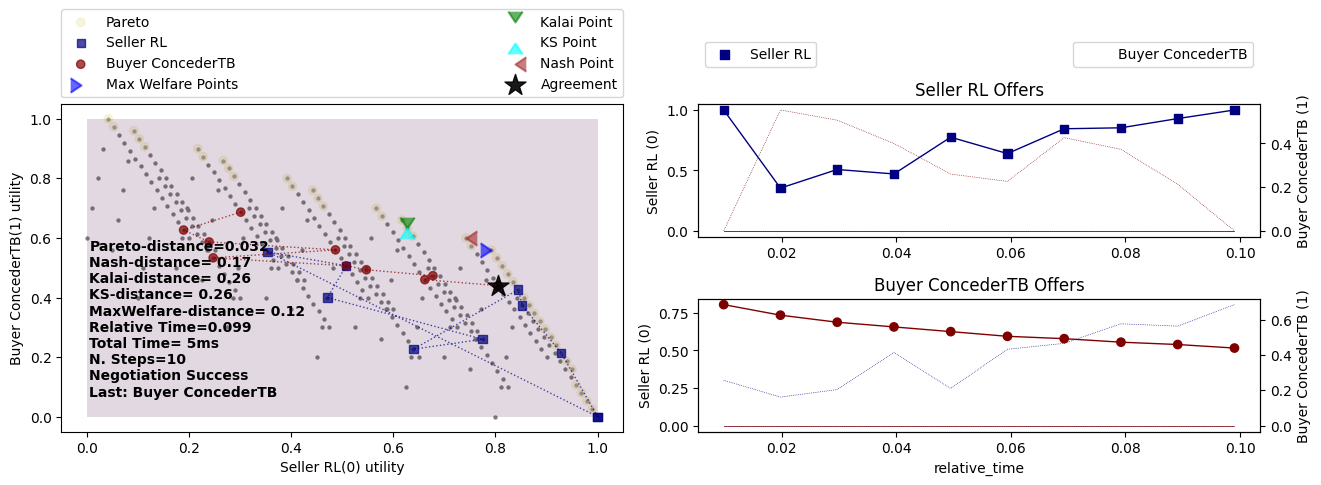

In [10]:
test_negotiation(trained)

Of course in actual deployment, you will need to save the model after training to secondary storage and then load it using `stable-baselines3`'s native (`save()` and `load()`) methods or any other approriate method.

## Training and testing using different scenarios

In the example above, the scenario generator generarted the same scenario every time. Let's change it to generate different scenarios with different utility functions:

In [11]:
from random import random as rand, randint
def TradeScenarioGenerator(indx: int | None = None) -> Scenario:
    """Generates scenarios for training and testing."""
    # 0. Helper function to generate new carbon values and weights
    def mk_carbon_weights():
        carbon = [rand(), rand(), rand()]
        m = max(carbon)
        carbon = [_/m for _ in carbon]
        weights = [rand(), rand(), rand()]
        s = sum(weights)
        weights = [_/s for _ in weights]
        return carbon, weights
        
    # 1. Define the outcome space
    os = make_os(
        [
            make_issue((1, randint(5, 7)), "price"),
            make_issue((1, randint(6, 20)), "quantity"),
            make_issue(["high", "med", "low"], "carbon emission"),
        ],
        name="Trade",
    )
    # 2. Define the sell-side utility function
    mxp = os.issues[0].max_value - 1
    mxq = os.issues[1].max_value - 1
    carbon, weights = mk_carbon_weights()
    
    seller_ufun = LU(
        (
            AffineFun(1 / mxp, -1 / mxp),
            AffineFun(1 / mxq, -1 / mxq),
            TableFun(dict(zip(os.issues[2].values, carbon))),
        ),
        weights=weights,
        outcome_space=os,
        reserved_value=rand() * 0.2,
        name="seller",
    )        
    
    # 3. Define  the buy-side utility function        
    sep = randint(2, mxq-1)
    carbon, weights = mk_carbon_weights()
    
    buyer_ufun = LU(
        (
            AffineFun(-1 / mxp, (mxp+1) / mxp),
            LambdaFun(
                lambda x: (
                    x / (sep-1) - 1 / (sep-1) 
                    if x <= sep 
                    else (
                        (-1 / (mxq+2-sep)) * (x - sep) 
                        + (mxq+3-sep) / (mxq+2-sep)
                    )
                )
            ),
            TableFun(dict(zip(os.issues[2].values, carbon))),                
        ),
        weights=weights,
        outcome_space=os,
        reserved_value=rand() * 0.1,
        name="buyer",
    )
    
    # 4. Return the constructed scenario
    return Scenario(os, (seller_ufun, buyer_ufun))  # type: ignore



We can now test that this generator generates different scenarios by plotting a couple:

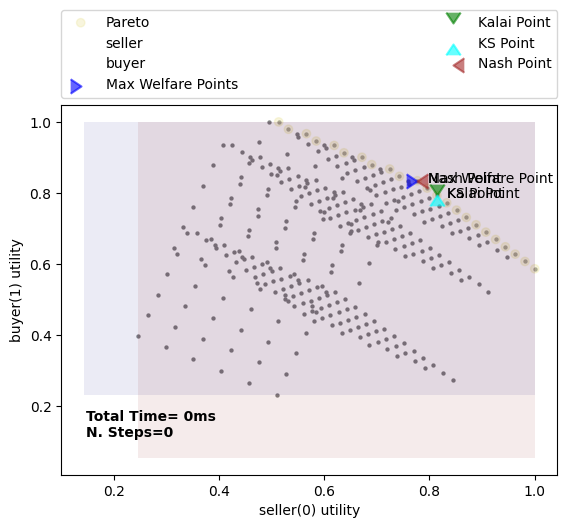

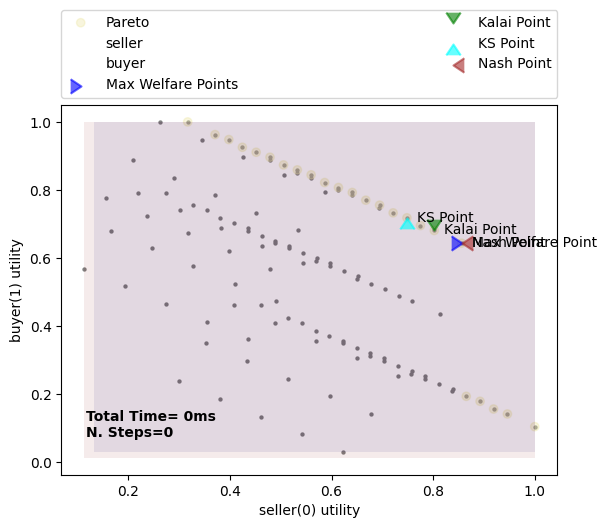

In [12]:
TradeScenarioGenerator().plot()
TradeScenarioGenerator().plot()

We can simply repalce the environment generator `make_env()` in the code above and train/test an RL agent for this much more challenging case:

In [13]:
untrained = make_trainer()
trained = train(make_trainer(), 5 * NTRAIN)
print(f"Untrained model got {test(untrained):3.2}")
print(f"Trained model got {test(trained):3.2}")

 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 49,980/50,000  [ 0:06:04 < 0:00:01 , 133 it/s ]

Untrained model got 0.75

Trained model got 0.64

and test the deployment:

Example ended with agreement (1, 6, 'high'): Seller gets 0.606, Buyer gets  1.0

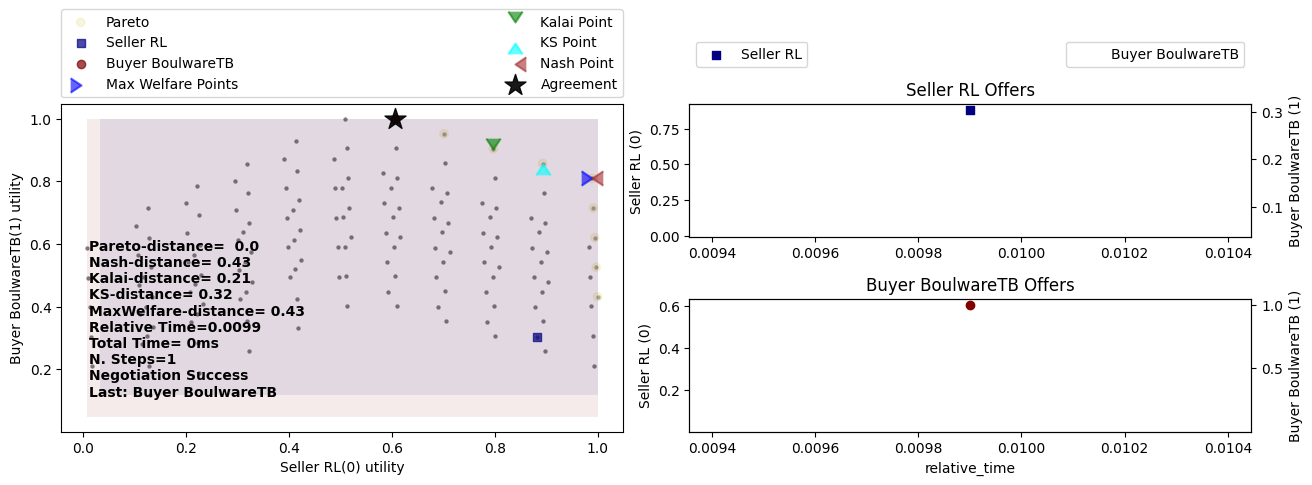

In [14]:
test_negotiation(trained)

Despite the much harder problem faced by this RL negotiator, it was able to learn a good strategy against time-based agents. It may not perform very well against other agents though. Let's try playing it against a different agent. Let's try it against Atlas3.

<div class="admonition note">
    <p class="admonition-title">Note</p>
    <p>
        You need to run the negmas-genius bridge in the background for this to work reliably. See <a href="https://negmas.readthedocs.io/en/latest/tutorials/02.integrating_with_genius.html">NegMAS documentation</a> for how to do that.
    </p>
</div>

Example ended with agreement (5, 16, 'high'): Seller gets 0.845, Buyer gets 0.808

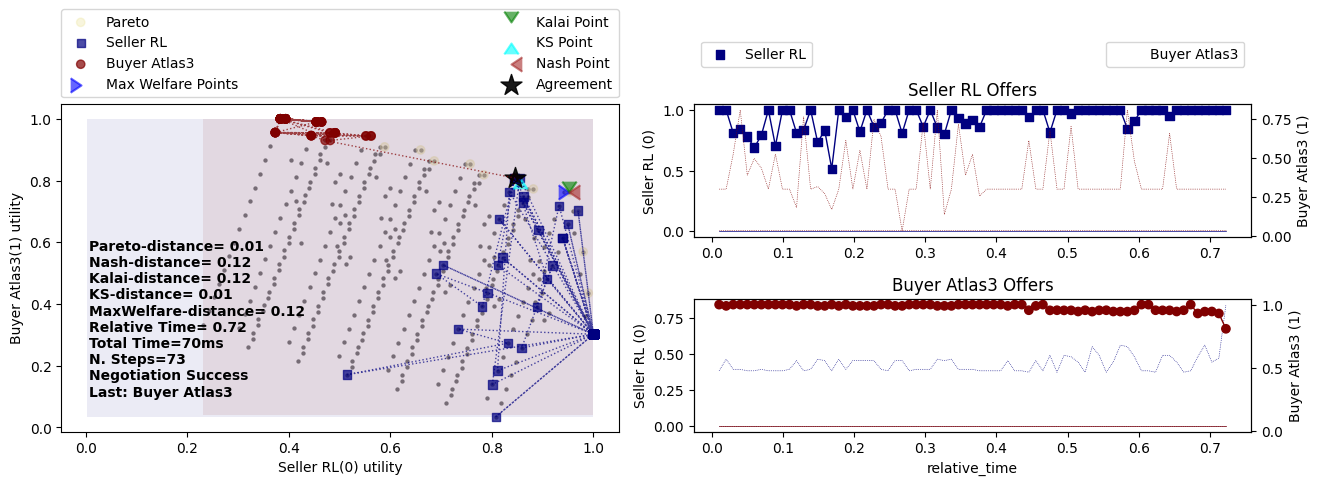

In [15]:
from negmas.genius.gnegotiators import Atlas3
test_negotiation(trained, (Atlas3,))

Example ended with agreement (3, 10, 'low'): Seller gets 0.752, Buyer gets 0.73

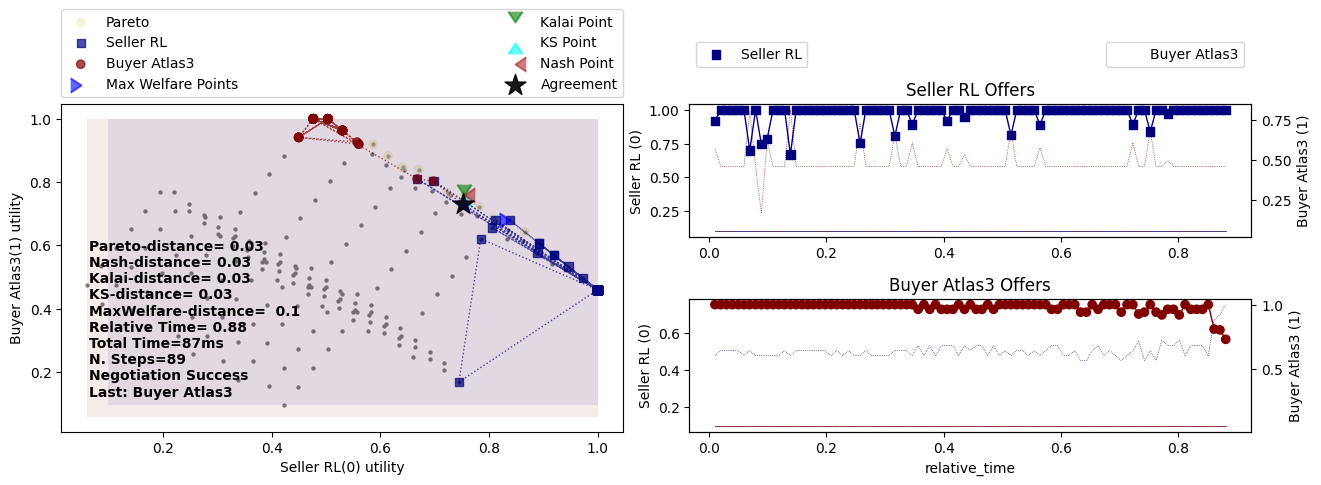

In [16]:
test_negotiation(trained, (Atlas3,))

Example ended with agreement (1, 9, 'med'): Seller gets 0.665, Buyer gets 0.999

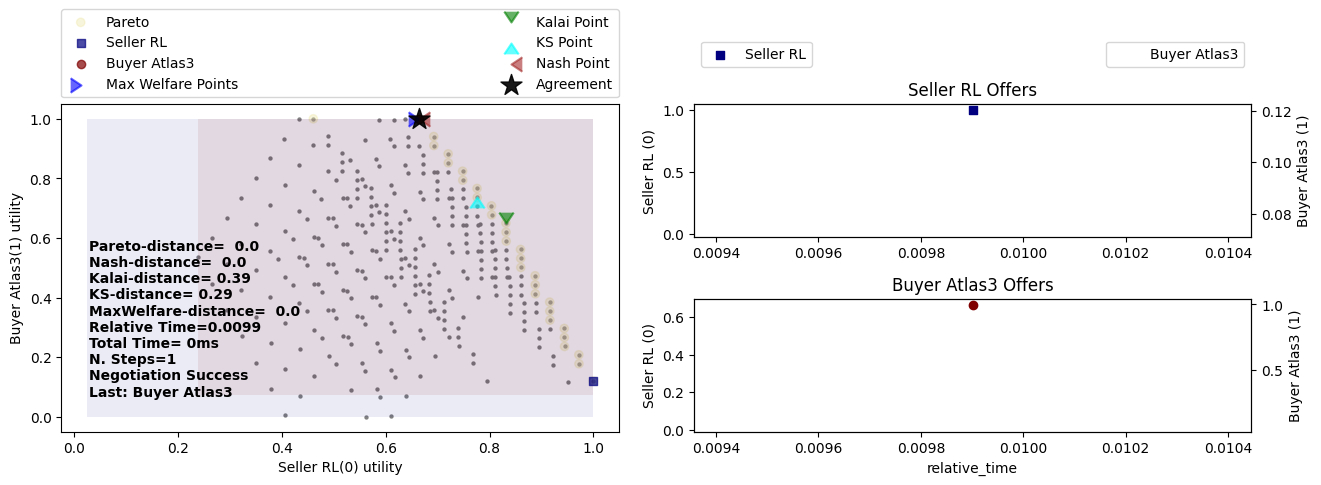

In [17]:
test_negotiation(trained, (Atlas3,))

Not so bad. We can now try it against itself (this means running it for both sell and buy sides without training it for the buy side):

Example ended with agreement (7, 17, 'med'): Seller gets  1.0, Buyer gets 0.616

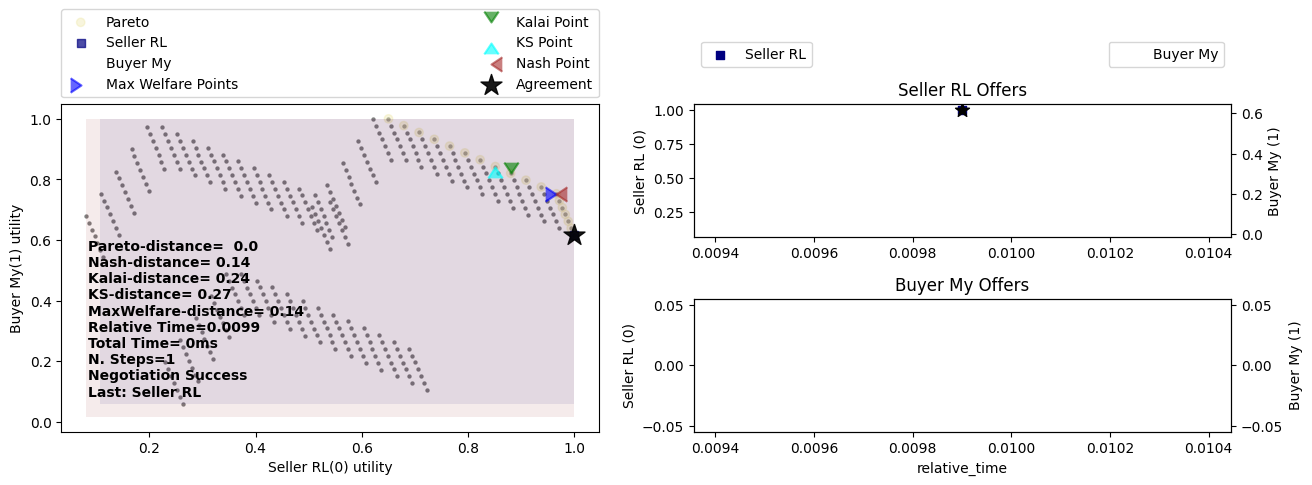

In [18]:
def MyNegotiator(name):    
    return SAORLNegotiator(
        policy=partial(make_policy, model=trained), name=name
    )
test_negotiation(trained, (MyNegotiator,))

Example ended with agreement (1, 3, 'med'): Seller gets 0.287, Buyer gets  1.0

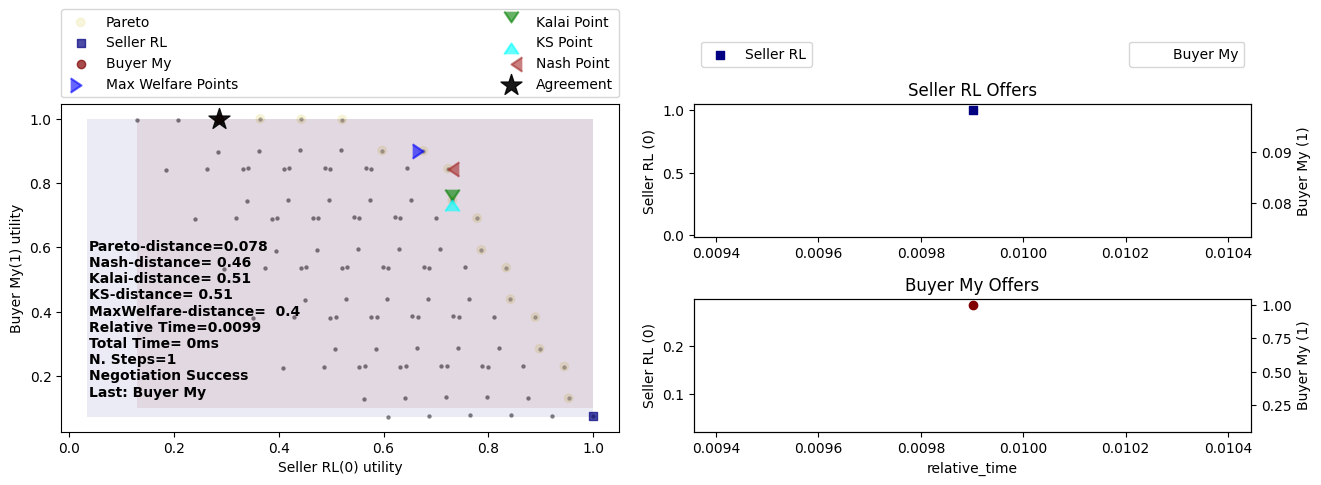

In [19]:
test_negotiation(trained, (MyNegotiator,))

Example ended with agreement (5, 9, 'high'): Seller gets  1.0, Buyer gets 0.61

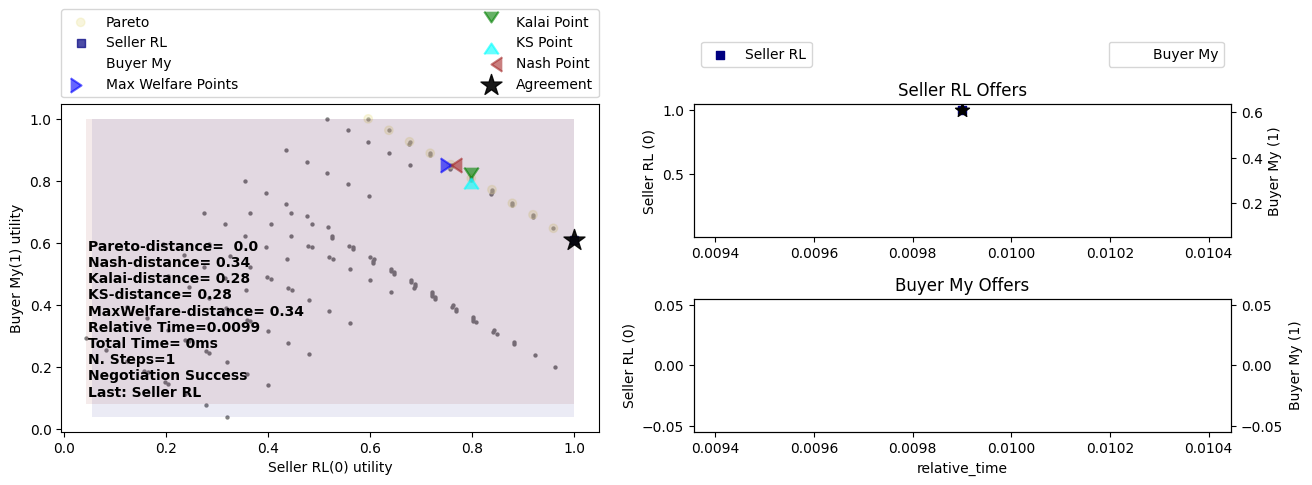

In [20]:
test_negotiation(trained, (MyNegotiator,))

Example ended with agreement (1, 4, 'high'): Seller gets 0.425, Buyer gets  1.0

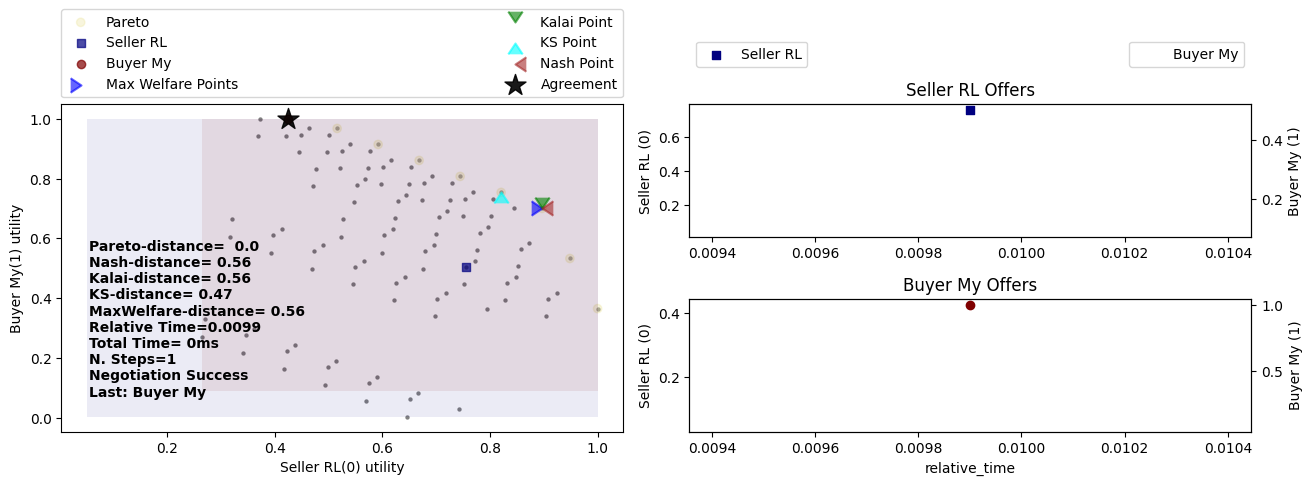

In [21]:
test_negotiation(trained, (MyNegotiator,))

Example ended with agreement (5, 7, 'low'): Seller gets 0.74, Buyer gets 0.613

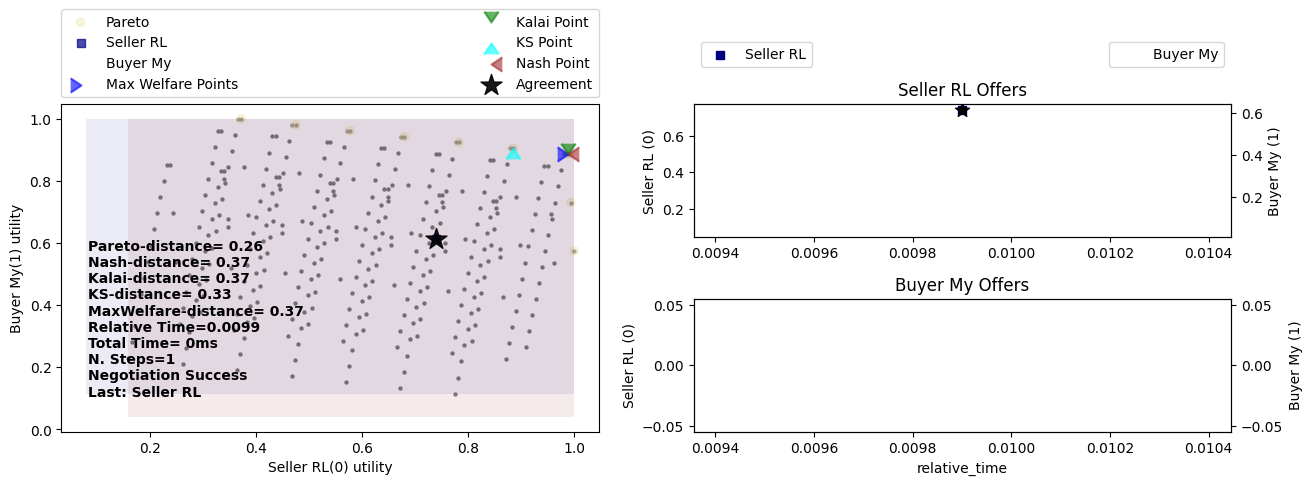

In [22]:
test_negotiation(trained, (MyNegotiator,))